In [44]:
import math
import os
import json
import uuid
import re
import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram, melfilterbank
import IPython.display as Ipd
from torchsummary import summary

In [3]:
def determine_is_stridor(path):
    """
    Determine if the path should be marked as stridor based on the parent folder.
    """
    for part in path.split(os.sep):
        if part.upper() in ["CONTROL", "CONTROLS"]:
            return False
    return True

def generate_recording_objects(root_path, output_json):
    recordings = []

    # Traverse the directory structure
    for root, dirs, files in os.walk(root_path):
        # Check if there are wav files in the current directory
        wav_files = [file for file in files if file.endswith('.wav')]
        if wav_files:
            # Get the parent folder name
            parent_folder = os.path.basename(root)
            # Determine the isStridor value
            is_stridor = determine_is_stridor(root)
            
            for wav_file in wav_files:
                # Generate a unique ID for each player-session-recording combination
                uid = str(uuid.uuid4())
                # Extract the recording label (base name without extension)
                recording_label = os.path.splitext(wav_file)[0]
                # Create the entry for the current recording
                entry = {
                    "uid": uid,
                    "name": parent_folder,
                    "recording": os.path.join(root, wav_file),  # Include the full path
                    "recording_label": recording_label,
                    "isStridor": is_stridor
                }
                recordings.append(entry)
                
    return recordings

In [4]:
def filter_recordings_by_label(data, label_prefix):
    """
    Filter recordings to only include those with recording_label starting with the specified prefix.
    Exclude specific labels when the prefix is 'FIMO'.
    """
    exclude_labels = {"FIMO": ["FIMOcricoid", "FIMOthyroid", "FIMOC", "FIMOT"]}

    filtered_data = []
    for recording in data:
        if recording['recording_label'].startswith(label_prefix):
            if label_prefix == "FIMO" and recording['recording_label'] in exclude_labels["FIMO"]:
                continue
            filtered_data.append(recording)

    return filtered_data

In [45]:
# Usage
root_path = 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files'  # Replace with the actual path to your folders
stridor_labels = 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Stridor_Labels.csv' # Replace with stridor labels csv
output_json = 'output_individual.json'  # Replace with the desired output JSON file name
data = generate_recording_objects(root_path, output_json)

print(f"rcordings: {data}")

rcordings: [{'uid': '41a59acb-54f9-4018-b909-0549bc8ad502', 'name': 'Patient 1', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 1\\FEMCcricoid.wav', 'recording_label': 'FEMCcricoid', 'isStridor': True}, {'uid': '4a01f178-a50d-4095-96a7-b8a156f813a9', 'name': 'Patient 1', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 1\\FEMOcricoid.wav', 'recording_label': 'FEMOcricoid', 'isStridor': True}, {'uid': 'e405a1c5-db28-4f8f-99d8-f7cb4efae7d9', 'name': 'Patient 1', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 1\\FEMOthyroid.wav', 'recording_label': 'FEMOthyroid', 'isStridor': True}, {'uid': '5c205a56-c195-4151-afdf-828ec8e27f23', 'name': 'Patient 1'

In [46]:
# Filter the data to only include recordings with recording_label starting with "FIMO"
filtered_data = filter_recordings_by_label(data, "FIMO")

print(f"filtered recordings: {filtered_data}")

filtered recordings: [{'uid': 'c3fe9b66-a1fa-46e7-a90f-71c7db46fe30', 'name': 'Patient 2', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 2\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': '2daf3193-0b70-4a4a-8895-078ce8ab53fb', 'name': 'Patient 3', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 3\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': 'f7fd755c-3695-4bb9-87c2-e0124c2ecaa1', 'name': 'Patient 4', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 4\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': '8fa0950f-6434-4c02-8893-dfe638cd30af', 'name': 'Patien

In [60]:
df = pd.DataFrame(data)
stridor_df = pd.read_csv(stridor_labels)
stridor_df['isStridor'] = stridor_df['Status'].apply(lambda x: False if 'No-Stridor' in x else True)
stridor_df = df.rename(columns={'Name': 'name'})
merged = pd.merge(df, stridor_df, on='name', how='left')
merged['Status']

KeyError: 'Status'

In [25]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, segment_size=3):
        self.dataframe = dataframe
        self.segment_size = segment_size
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording', 'recording_label', 'isStridor']
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.labels = dataframe['isStridor'].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        recording_label = self.recording_labels[idx]

        try:
            audio = Audio.from_file(self.audio_files[idx])
            audio = audio.to_16khz()
            # get middle K seconds if audio is too long, pad with zeros if it is too short
            if audio.signal.size(0) > self.segment_size*16000:
                d = (audio.signal.size(0)-self.segment_size*16000)//2
                audio.signal = audio.signal[d:d+self.segment_size*16000]
            else:
                audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)
                
            win_length = 30
            hop_length = 10
            nfft = 512
            features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
            features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))
            features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
            mel_specgram = melfilterbank(features_specgram)

        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.float32)

        return {'uid': uid, 'signal': mel_specgram, 'isStridor': label, 'recording_label': recording_label}

dataset: <__main__.MySpecgramDataset object at 0x000001F8BCFFEE70>
['RegAvid', 'RPiPad', 'FEMCavid', 'RMOcricoid', 'DeepiPad', 'FIMOthyroid', 'RMOcricoid', 'DeepiPad'] tensor([1., 1., 0., 1., 1., 1., 0., 1.])
shape: torch.Size([256, 20])


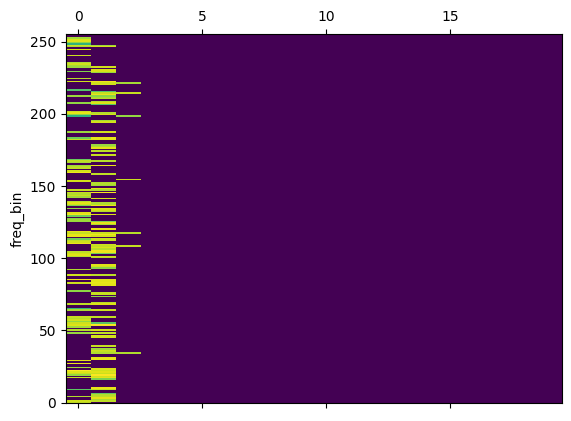

In [27]:
dataset = MySpecgramDataset(df)
print(f"dataset: {dataset}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    #batch['mel'] = melfilterbank(batch['signal'])
    print(batch['recording_label'], batch['isStridor'])
    plot_spectrogram(batch['signal'][0])
    #plot_spectrogram(batch['mel'][0])
    print("shape:", batch['signal'][0].shape )
    break

In [28]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(torch.nn.Module):
    def __init__(self, ntoken, nout, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = torch.nn.Linear(ntoken, ninp)
        self.ninp = ninp
        self.decoder = torch.nn.Linear(ninp, nout)

    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

In [11]:
transformer = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 1,
    heads = 4,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

#img = torch.randn(1, 2, 301, 256)

#preds = transformer(img) # (1, 1000)

In [31]:
transformer = TransformerModel(20, 1, 256, 4, 512, 2, 0.1)
#for batch in val_dataloader:
    #print(batch['signal'][0].shape)
# _ = summary(transformer, (257, 301))

In [32]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		with torch.no_grad():
			outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['isStridor'][i]
			else:
				acc += 1.0-batch['isStridor'][i]
	return acc/len(dataloader.dataset)	

num_epochs = 10
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
	transformer.train()
	
	closs = []
	for batch in train_dataloader:
		optimizer.zero_grad()
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
		loss = torch.nn.functional.binary_cross_entropy(outputs, batch['isStridor'].float())
		closs += [loss.item()]*len(batch['signal'])
		loss.backward()
		optimizer.step()

	val_acc = eval(transformer, val_dataloader)
	print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(transformer, train_dataloader), val_acc))

	if val_acc >= best_val_acc:
		best_val_acc = val_acc
		torch.save(transformer.state_dict(), './my_transformer_model.pth')
		print('Saved!')

Epoch:1 TrainLoss:0.6898 TrainACC:0.6042 ValACC:0.6528
Saved!
Epoch:2 TrainLoss:0.6745 TrainACC:0.6198 ValACC:0.6806
Saved!
Epoch:3 TrainLoss:0.6757 TrainACC:0.4878 ValACC:0.4583
Epoch:4 TrainLoss:0.6595 TrainACC:0.6128 ValACC:0.6389
Epoch:5 TrainLoss:0.6706 TrainACC:0.5590 ValACC:0.5556
Epoch:6 TrainLoss:0.6647 TrainACC:0.6146 ValACC:0.6806
Saved!
Epoch:7 TrainLoss:0.6766 TrainACC:0.6215 ValACC:0.6806
Saved!
Epoch:8 TrainLoss:0.6613 TrainACC:0.6233 ValACC:0.6806
Saved!
Epoch:9 TrainLoss:0.6662 TrainACC:0.6354 ValACC:0.6944
Saved!
Epoch:10 TrainLoss:0.6640 TrainACC:0.6181 ValACC:0.6806


In [33]:
transformer.load_state_dict(torch.load('./my_transformer_model.pth'))
test_acc = eval(transformer, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

TestACC:0.6438


In [34]:
transformer.eval()
acc = [0, 0]
total = [0, 0]
for batch in test_dataloader:
	with torch.no_grad():
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
	for i in range(len(batch['signal'])):
		total[int(batch['isStridor'][i])] += 1
		if outputs[i].item() > 0.5:
			acc[int(batch['isStridor'][i])] += batch['isStridor'][i]
		else:
			acc[int(batch['isStridor'][i])] += 1.0-batch['isStridor'][i]

print('Class #0 ({}) ACC:{:.4f} Class #1 ({}) ACC:{:.4f}'.format(total[0], acc[0]/total[0], total[1], acc[1]/total[1]))

Class #0 (25) ACC:0.0400 Class #1 (48) ACC:0.9583
